# **INSTALL LIBRARY**

In [ ]:
!pip install split-folders
!pip install kaggle

# **IMPORT LIBRARY**

In [ ]:
import os
import cv2
import PIL
import pathlib
import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import splitfolders
import seaborn as sns
sns.set()
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

# **IMPORT DATA**

In [ ]:
!kaggle datasets download -d arghianfaizalyusup/dataset-penyakit-kulit

Dataset URL: https://www.kaggle.com/datasets/arghianfaizalyusup/dataset-penyakit-kulit
License(s): unknown
dataset-penyakit-kulit.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip dataset-penyakit-kulit.zip -d /content/dataset-penyakit-kulit

Archive:  dataset-penyakit-kulit.zip
replace /content/dataset-penyakit-kulit/Dataset/Acne and Rosacea Photos/07Acne081101.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
base_dir = '/content/dataset-penyakit-kulit/Dataset'
print(os.listdir(base_dir))

['Poison Ivy Photos and other Contact Dermatitis', 'Nail Fungus', 'Shingles', 'Melanoma Skin Cancer Nevi and Moles', 'Herpes HPV and other STDs', 'Impetigo', 'Seborrheic Keratoses and other Benign Tumors', 'Atopic Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Light Diseases and Disorders of Pigmentation', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Systemic Disease', 'Acne and Rosacea Photos', 'Warts Molluscum and other Viral Infections', 'Eczema', 'Chickenpox', 'Cutaneous Larva Migrans', 'Lupus and other Connective Tissue diseases', 'Athlete Foot', 'Exanthems and Drug Eruptions', 'Ringworm', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Cellulitis Impetigo and other Bacterial Infections', 'Vasculitis']


# **SPLITTING DATA**

In [ ]:
splitfolders.ratio(base_dir, output="Penyakit", ratio=(0.9, 0, 0.1))

Copying files: 4093 files [00:06, 662.60 files/s]


In [ ]:
train_dir = '/content/Penyakit/train'
test_dir = '/content/Penyakit/test'
data_dir = '/content/Penyakit/'

In [ ]:
num_test_images = len(os.listdir(test_dir))
num_train_images = len(os.listdir(train_dir))
print(f'Number of test images: {num_test_images}')
print(f'Number of train images: {num_train_images}')

class_names = sorted(os.listdir(test_dir))
num_classes = len(class_names)

class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)


img_size = (192, 192, 3)
print('classes: ', class_names)

Number of test images: 26
Number of train images: 26
classes:  ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Athlete Foot', 'Atopic Dermatitis', 'Cellulitis Impetigo and other Bacterial Infections', 'Chickenpox', 'Cutaneous Larva Migrans', 'Eczema', 'Exanthems and Drug Eruptions', 'Herpes HPV and other STDs', 'Impetigo', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Ringworm', 'Seborrheic Keratoses and other Benign Tumors', 'Shingles', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis', 'Warts Molluscum and other Viral Infections']


# **MODEL**

**Visualizing the results**

In [ ]:
# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 3274 images belonging to 3 classes.
Found 818 images belonging to 3 classes.


In [ ]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [ ]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """

    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (15, 10))

    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()
    plt.show()

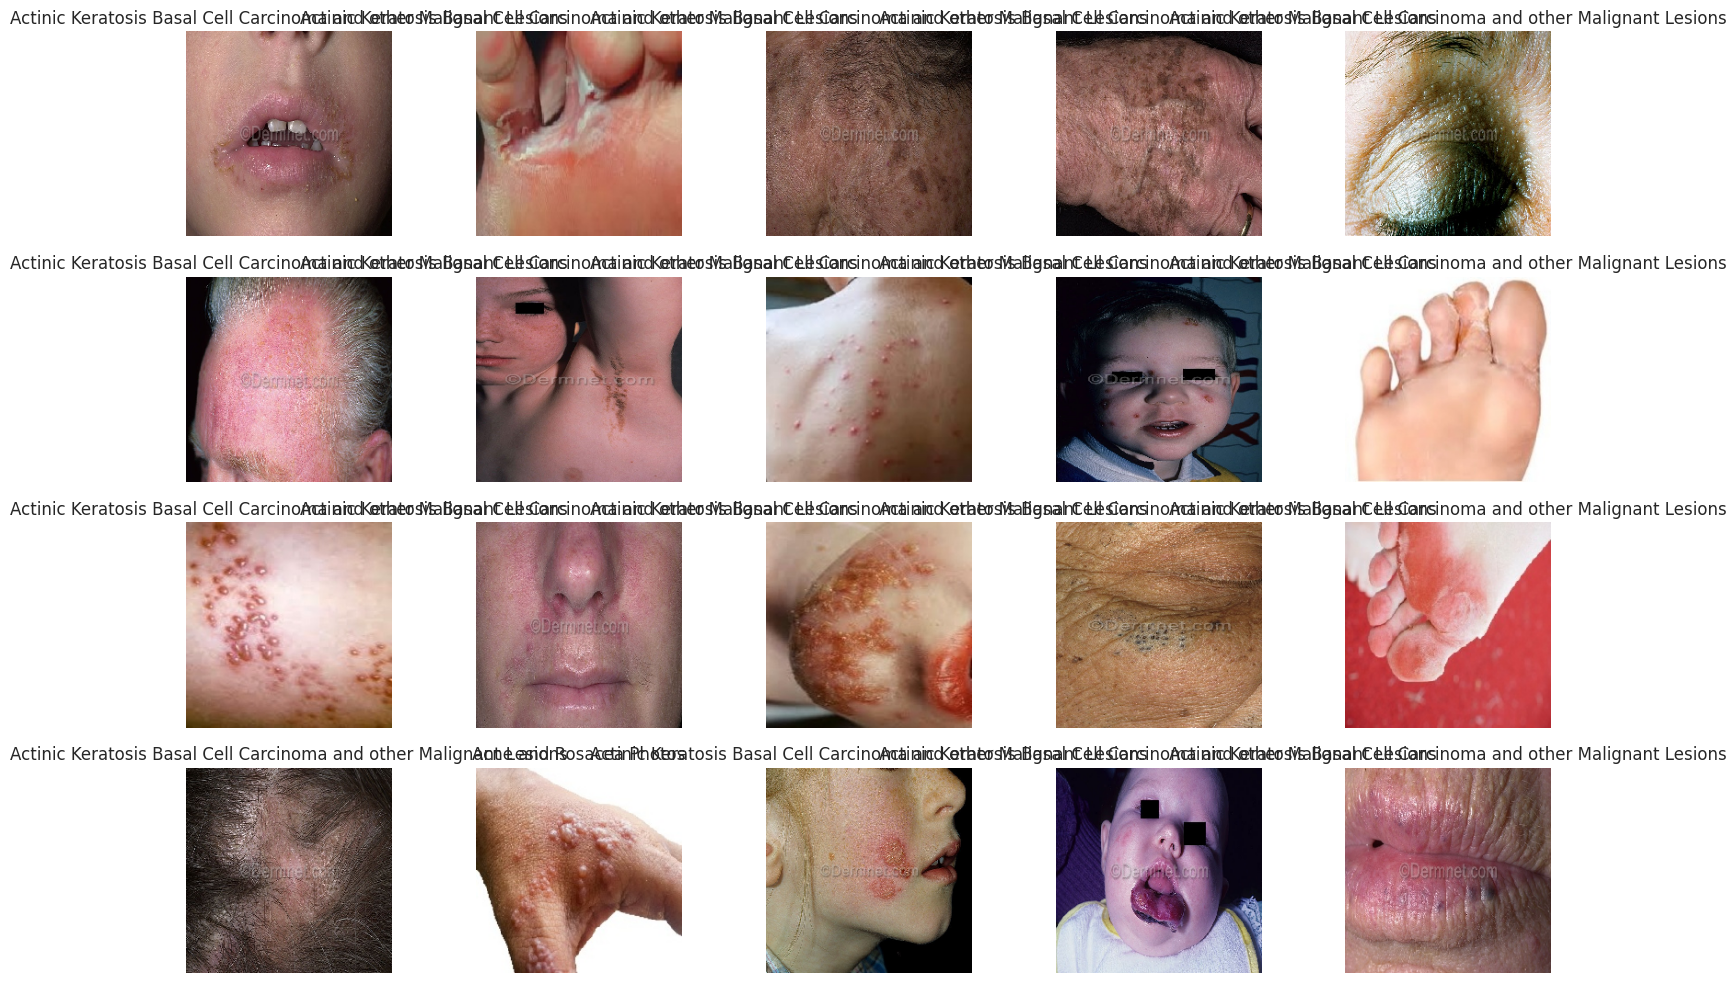

In [ ]:
plot_random_images()

**Baseline Model**

In [ ]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs= 15,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/15
103/103 [==============================] - 268s 3s/step - loss: 1.1223 - accuracy: 0.8809 - val_loss: 0.3840 - val_accuracy: 0.8973
Epoch 2/15
103/103 [==============================] - 253s 2s/step - loss: 0.3420 - accuracy: 0.8971 - val_loss: 0.3453 - val_accuracy: 0.8973
Epoch 3/15
103/103 [==============================] - 264s 3s/step - loss: 0.2883 - accuracy: 0.9044 - val_loss: 0.3544 - val_accuracy: 0.8949
Epoch 4/15
103/103 [==============================] - 254s 2s/step - loss: 0.2212 - accuracy: 0.9261 - val_loss: 0.4053 - val_accuracy: 0.8936
Epoch 5/15
103/103 [==============================] - 254s 2s/step - loss: 0.1748 - accuracy: 0.9420 - val_loss: 0.3888 - val_accuracy: 0.8888
Epoch 6/15
103/103 [==============================] - 256s 2s/step - loss: 0.1431 - accuracy: 0.9505 - val_loss: 0.5215 - val_accuracy: 0.8912
Epoch 7/15
103/103 [==============================] - 254s 2s/step - loss: 0.1308 - accuracy: 0.9603 - val_loss: 0.6202 - val_accuracy: 0.8924

In [ ]:
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = accuracy, label='Training Accuracy', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set(title = 'Accuracy', xlabel = 'Epochs')

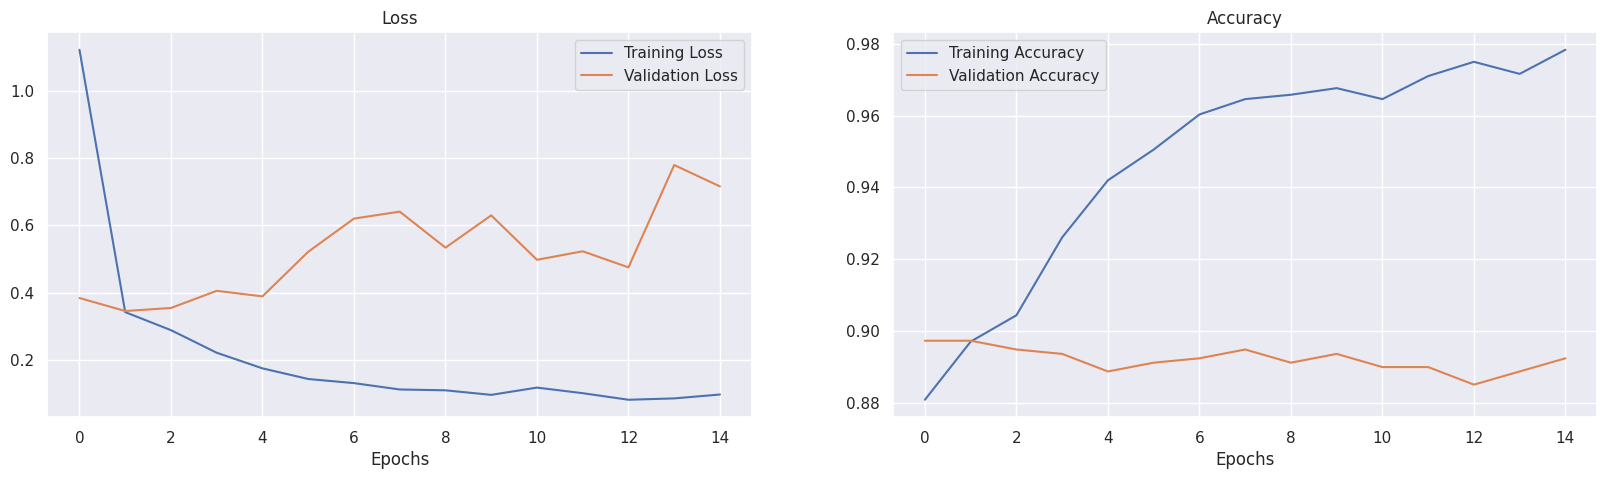

In [ ]:
plot_loss_curves(history_1)

**Transfer Learning**

In [ ]:
url = 'https://tfhub.dev/google/efficientnet/b7/feature-vector/1'

feature_extractor_layer = hub.KerasLayer(url,
                                         trainable=False,
                                         input_shape=(224, 224, 3))

model_5 = Sequential([
    feature_extractor_layer,
    Dense(1, activation = 'sigmoid')
])

model_5.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_5 = model_5.fit(train_data,
                        epochs= 15,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/15
 85/103 [=======================>......] - ETA: 5:28 - loss: 0.3883 - accuracy: 0.8777

KeyboardInterrupt: 

**Max Pooling Layer**

In [ ]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
     MaxPool2D(pool_size = 2),# It will reduce the number of features by half
    Conv2D(filters = 32, kernel_size =2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
103/103 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.8897

KeyboardInterrupt: 